In [1]:
pip install jupyterlab_tabnine


     -------------------------------------- 178.9/178.9 kB 3.6 MB/s eta 0:00:00


In [1]:
import dask
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, progress
import joblib

import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import os

import plotly.express as px
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

mpl.rcParams['figure.figsize']=(10,8)
mpl.rcParams['axes.grid']= False

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', None)

In [2]:
client = Client(processes=False)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.1.100:8787/status,
Dashboard: http://192.168.1.100:8787/status,Workers: 1
Total threads: 8,Total memory: 15.41 GiB
Status: running,Using processes: False
Comm: inproc://192.168.1.100/11456/1,Workers: 1
Dashboard: http://192.168.1.100:8787/status,Total threads: 8
Started: Just now,Total memory: 15.41 GiB
Comm: inproc://192.168.1.100/11456/4,Total threads: 8
Dashboard: http://192.168.1.100:54511/status,Memory: 15.41 GiB
Nanny: None,


In [3]:
start_time = datetime.now()
df = dd.read_csv("subset.csv")

In [4]:
df

,Unnamed: 0,MEDIUM_ID,NDR_BASKET_ITEM_TREND_FACTOR,weekday,month,day,en_TRANSCRIPTION,en_TRANSCRIBED,en_IS_CLEANSED,descriptor_GTIN,descriptor_RIN,descriptor_RSD,BASKET_ITEM_ID_dup,BASKET_ID_dup,ITEM_ID_dup
npartitions=2,,,,,,,,,,,,,,,
,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
#pip install dask-ml

In [5]:
print(df.dtypes)

Unnamed: 0                        int64
MEDIUM_ID                         int64
NDR_BASKET_ITEM_TREND_FACTOR    float64
weekday                           int64
month                             int64
day                               int64
en_TRANSCRIPTION                  int64
en_TRANSCRIBED                    int64
en_IS_CLEANSED                    int64
descriptor_GTIN                   int64
descriptor_RIN                    int64
descriptor_RSD                    int64
BASKET_ITEM_ID_dup                int64
BASKET_ID_dup                     int64
ITEM_ID_dup                       int64
dtype: object


In [6]:
df = df.drop("Unnamed: 0", axis=1)

In [7]:
arr = df.to_dask_array(lengths=[len(df), len(df.columns)])

# Compute the Dask Array to get the actual numpy array
#arr = da.compute(arr)[0]
#arr = arr.compute()

In [8]:
# Compute the Dask Array to get the actual numpy array
arr = da.compute(arr)[0]

In [9]:
with joblib.parallel_backend('dask'):
    model = IsolationForest(contamination = 0.001, max_features= 14, max_samples = 0.8, n_estimators = 200)
    model.fit(arr)

In [10]:
# Convert numpy array to Dask Array
arr = da.from_array(arr)

# Convert Dask Array to Dask DataFrame
df = dd.from_dask_array(arr, columns=df.columns)

In [13]:
# Predict outliers using the trained model
predicted = model.predict(arr)
outliers = da.from_array(predicted).map_blocks(lambda x: np.where(x == -1, 'yes', 'no'),dtype='object')

In [14]:
# Convert Dask Array to Dask DataFrame
df_outliers = dd.from_dask_array(outliers)

In [15]:
# Assign the outliers to the original dataframe
df['outliers'] = df_outliers

In [19]:
df.head(10)

,MEDIUM_ID,NDR_BASKET_ITEM_TREND_FACTOR,weekday,month,day,en_TRANSCRIPTION,en_TRANSCRIBED,en_IS_CLEANSED,descriptor_GTIN,descriptor_RIN,descriptor_RSD,BASKET_ITEM_ID_dup,BASKET_ID_dup,ITEM_ID_dup,outliers
0,1.0,1.211461,5.0,11.0,26.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,886.0,no
1,5.0,1.211461,2.0,11.0,23.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,4.0,753.0,no
2,1.0,1.211461,1.0,12.0,6.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,6.0,886.0,no
3,5.0,1.211461,2.0,11.0,23.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,4.0,886.0,no
4,1.0,1.211461,6.0,11.0,27.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,6.0,584.0,no
5,1.0,1.211461,3.0,11.0,24.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,584.0,no
6,1.0,1.211461,0.0,11.0,28.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,10.0,255.0,no
7,1.0,1.211461,3.0,11.0,24.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,2.0,255.0,no
8,1.0,1.211461,3.0,11.0,24.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,4.0,255.0,no
9,1.0,1.211461,4.0,11.0,25.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,8.0,81.0,no


In [20]:
score = model.decision_function(arr)

In [21]:
score

array([0.16425635, 0.07714754, 0.13756468, ..., 0.15262917, 0.24755216,
       0.24342205])

(array([1.00000e+00, 2.00000e+00, 3.00000e+00, 1.50000e+01, 1.80000e+01,
        3.90000e+01, 4.10000e+01, 7.10000e+01, 1.04000e+02, 1.34000e+02,
        1.71000e+02, 2.93000e+02, 3.39000e+02, 4.78000e+02, 5.77000e+02,
        8.19000e+02, 1.09700e+03, 1.41900e+03, 1.93700e+03, 2.45100e+03,
        3.17900e+03, 4.03100e+03, 4.95800e+03, 6.23700e+03, 7.79700e+03,
        9.51800e+03, 1.12080e+04, 1.39740e+04, 1.66870e+04, 1.93460e+04,
        2.31240e+04, 2.80260e+04, 3.35340e+04, 3.89230e+04, 4.36660e+04,
        4.80080e+04, 5.29640e+04, 6.06250e+04, 7.51890e+04, 9.48090e+04,
        1.18277e+05, 1.52052e+05, 1.79136e+05, 2.04824e+05, 2.58459e+05,
        3.61598e+05, 5.10135e+05, 5.63414e+05, 3.82162e+05, 9.94980e+04]),
 array([-0.12446855, -0.11683977, -0.10921099, -0.10158221, -0.09395343,
        -0.08632465, -0.07869586, -0.07106708, -0.0634383 , -0.05580952,
        -0.04818074, -0.04055196, -0.03292318, -0.0252944 , -0.01766562,
        -0.01003684, -0.00240805,  0.00522073,  0

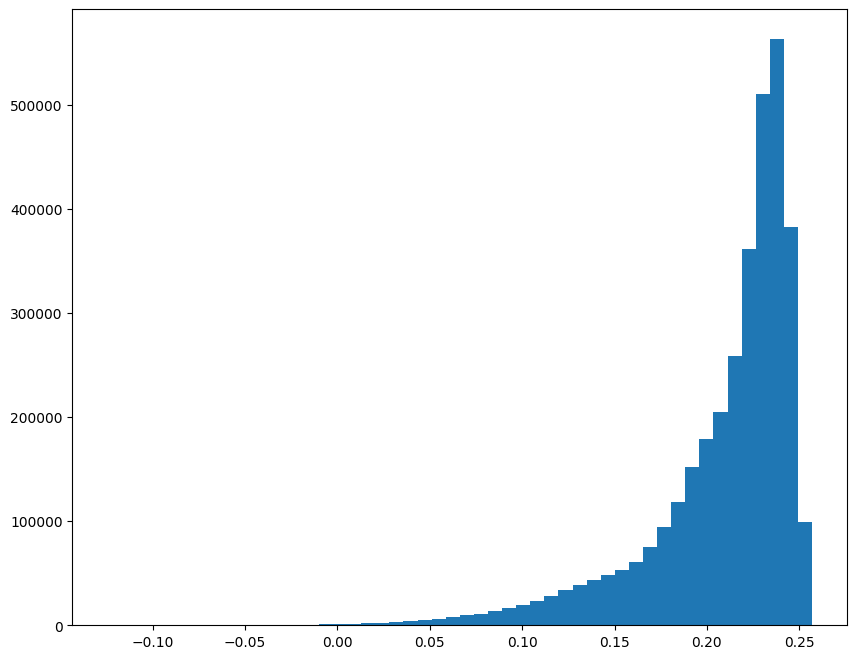

In [22]:
plt.hist(score,bins=50)

In [26]:
score_dask = da.from_array(score, chunks=score.shape)
df_scores = dd.from_dask_array(score_dask)

In [27]:
# Assign the outliers to the original dataframe
df['scores'] = df_scores

In [28]:
df.head()

,MEDIUM_ID,NDR_BASKET_ITEM_TREND_FACTOR,weekday,month,day,en_TRANSCRIPTION,en_TRANSCRIBED,en_IS_CLEANSED,descriptor_GTIN,descriptor_RIN,descriptor_RSD,BASKET_ITEM_ID_dup,BASKET_ID_dup,ITEM_ID_dup,outliers,scores
0,1.0,1.211461,5.0,11.0,26.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,886.0,no,0.164256
1,5.0,1.211461,2.0,11.0,23.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,4.0,753.0,no,0.077148
2,1.0,1.211461,1.0,12.0,6.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,6.0,886.0,no,0.137565
3,5.0,1.211461,2.0,11.0,23.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,4.0,886.0,no,0.075749
4,1.0,1.211461,6.0,11.0,27.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,6.0,584.0,no,0.157717


In [31]:
df.query('scores< 0.02')

,MEDIUM_ID,NDR_BASKET_ITEM_TREND_FACTOR,weekday,month,day,en_TRANSCRIPTION,en_TRANSCRIBED,en_IS_CLEANSED,descriptor_GTIN,descriptor_RIN,descriptor_RSD,BASKET_ITEM_ID_dup,BASKET_ID_dup,ITEM_ID_dup,outliers,scores
npartitions=3,,,,,,,,,,,,,,,,
0,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64
1198372,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2396744,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3435366,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [36]:
all_outliers=df.query('outliers == "yes"').compute()

(array([  1.,   0.,   0.,   0.,   0.,   2.,   0.,   2.,   1.,   5.,   0.,
          6.,   7.,   6.,   5.,   9.,  11.,   9.,  20.,  10.,  14.,  20.,
         31.,  24.,  15.,  37.,  34.,  42.,  49.,  41.,  42.,  52.,  63.,
         64.,  70.,  95., 117.,  89., 117., 143., 156., 160., 148., 180.,
        183., 212., 224., 254., 328., 338.]),
 array([-1.24468550e-01, -1.21979243e-01, -1.19489936e-01, -1.17000629e-01,
        -1.14511321e-01, -1.12022014e-01, -1.09532707e-01, -1.07043400e-01,
        -1.04554092e-01, -1.02064785e-01, -9.95754779e-02, -9.70861707e-02,
        -9.45968634e-02, -9.21075562e-02, -8.96182489e-02, -8.71289417e-02,
        -8.46396344e-02, -8.21503272e-02, -7.96610199e-02, -7.71717127e-02,
        -7.46824055e-02, -7.21930982e-02, -6.97037910e-02, -6.72144837e-02,
        -6.47251765e-02, -6.22358692e-02, -5.97465620e-02, -5.72572547e-02,
        -5.47679475e-02, -5.22786402e-02, -4.97893330e-02, -4.73000257e-02,
        -4.48107185e-02, -4.23214112e-02, -3.98321

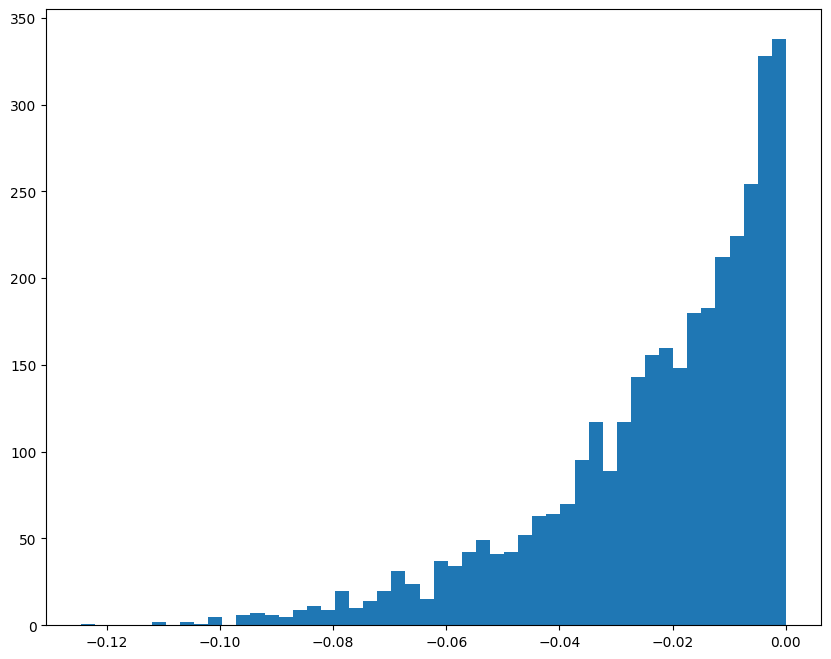

In [37]:
plt.hist(all_outliers['scores'],bins=50)

In [ ]:
anomalies = X[anomaly_scores < threshold]